In [ ]:
#import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from pandas import DataFrame
from IPython.display import display
from statsmodels.tsa.stattools import adfuller, grangercausalitytests

In [149]:
#function for loading in the time seires data
def load_timeseries_data(file_path: str, start_year: int = None) -> DataFrame:
    """
    Loads and preprocesses time-series data from a CSV file.

    :param file_path:  Path to the CSV file
    :param start_year: Optional starting year to filter data from
    :return:           Cleaned pandas DataFrame indexed by time
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"File not found: {file_path}")

    df = pd.read_csv(file_path, sep=';', parse_dates=["time"])
    df.dropna(axis=1, how='all', inplace=True)
    df.set_index("time", inplace=True)

    if start_year:
        start_date = f"{start_year}-01-01"
        df = df.loc[start_date:].copy()

    return df

In [150]:
#function for creating the dataframe for data analysis
def create_market_stats(futures_df: DataFrame, spot_df: DataFrame, risk_free_df: DataFrame, back_adjusted: bool = False, market_mtp: float = 300) -> DataFrame:
    """
    Creates a standardized market statistics DataFrame for futures and spot prices.

    :param futures_df:    DataFrame with futures data ('close', 'Volume', 'Futures Open Interest')
    :param spot_df:       DataFrame with spot market data ('close')
    :param risk_free_df:  DataFrame with risk-free rates ('close')
    :param back_adjusted: Boolean, if True compute Amihud illiquidity instead of abs_basis
    :param illiq_factor:  Scaling factor used in Amihud illiquidity calculation (default 300)
    :return:              DataFrame containing all computed statistics
    """
    stats = pd.DataFrame()
    
    stats['fut_close'] = futures_df['close']
    stats['spot_close'] = spot_df['close']
    stats['basis'] = stats['fut_close'] - stats['spot_close']
    stats['norm_basis'] = (stats['basis'] / stats['spot_close'])*100 #in pct

    stats['fut_ret'] = np.log(stats['fut_close']).diff()
    stats['spot_ret'] = np.log(stats['spot_close']).diff()

    stats['volume'] = futures_df['Volume']
    stats = stats[stats['volume'] > 0]
    
    stats['open_interest'] = futures_df['Futures Open Interest']
    stats['risk_free'] = risk_free_df['close']
    
    if back_adjusted:
        stats['amihud_illiq'] = 1e6 * abs(stats['fut_ret']) / (stats['volume'] * stats['fut_close'] * market_mtp)
    else:
        stats['abs_basis'] = abs(stats['basis'])

    stats.dropna(inplace=True)
    
    return stats

In [151]:
#reading in the files
csi_futures: DataFrame       = load_timeseries_data("../data/csi300_futures_csv.csv", 2017)
snp_futures: DataFrame       = load_timeseries_data("../data/snp500_futures_csv.csv", 2017)

csi_futures_badj: DataFrame  = load_timeseries_data("../data/csi300_futures_badj_csv.csv", 2017)
snp_futures_badj: DataFrame  = load_timeseries_data("../data/snp500_futures_badj_csv.csv", 2017)

csi_spot: DataFrame          = load_timeseries_data("../data/csi300_spot_csv.csv", 2017)
snp_spot: DataFrame          = load_timeseries_data("../data/snp500_spot_csv.csv", 2017)

rf_cn: DataFrame             = load_timeseries_data("../data/rf_cn.csv", 2017)
rf_us: DataFrame             = load_timeseries_data("../data/rf_us.csv", 2017)

cn_stats: DataFrame          = create_market_stats(csi_futures, csi_spot, rf_cn)
us_stats: DataFrame          = create_market_stats(snp_futures, snp_spot, rf_us)

cn_badj_stats: DataFrame     = create_market_stats(csi_futures_badj, csi_spot, rf_cn, back_adjusted=True, market_mtp=300)
us_badj_stats: DataFrame     = create_market_stats(snp_futures_badj, snp_spot, rf_us, back_adjusted=True, market_mtp=50)

#amihud is backadjusted everywhere
cn_stats["amihud_illiq"]     = cn_badj_stats["amihud_illiq"]
us_stats["amihud_illiq"]     = us_badj_stats["amihud_illiq"]

In [152]:
#function for calculating ohr and hr
def calculate_rolling_ohr_he(stats: DataFrame, window_size: int=60) -> DataFrame:
    """
    Calculates rolling OHR (Optimal Hedge Ratio) and HE (Hedging Effectiveness)
    using a rolling window regression of spot returns on futures returns.

    :param stats:       DataFrame containing at least 'spot_ret' and 'fut_ret' columns
    :param window_size: Number of observations in each rolling window (default 60)
    :return:            DataFrame with original stats plus 'ohr' and 'he' columns
    """
    ohr_list = []
    he_list = []
    dates_list = []

    for i in range(window_size, len(stats)):
        window = stats.iloc[i - window_size : i]

        Y = window['spot_ret']
        X = sm.add_constant(window['fut_ret'])

        model = sm.OLS(Y, X, missing='drop').fit()

        ohr_list.append(model.params['fut_ret'])
        he_list.append(model.rsquared)
        dates_list.append(window.index[-1])

    return pd.DataFrame({
        'ohr': ohr_list,
        'he': he_list
    }, index=dates_list)

In [153]:
#run ohr and he calculations and update the dataframes accordingly
cn_ohr = calculate_rolling_ohr_he(cn_badj_stats)
us_ohr = calculate_rolling_ohr_he(us_badj_stats)

cn_badj_stats = cn_badj_stats.join(cn_ohr)
us_badj_stats = us_badj_stats.join(us_ohr)

cn_stats = cn_stats.join(cn_ohr)
us_stats = us_stats.join(us_ohr)



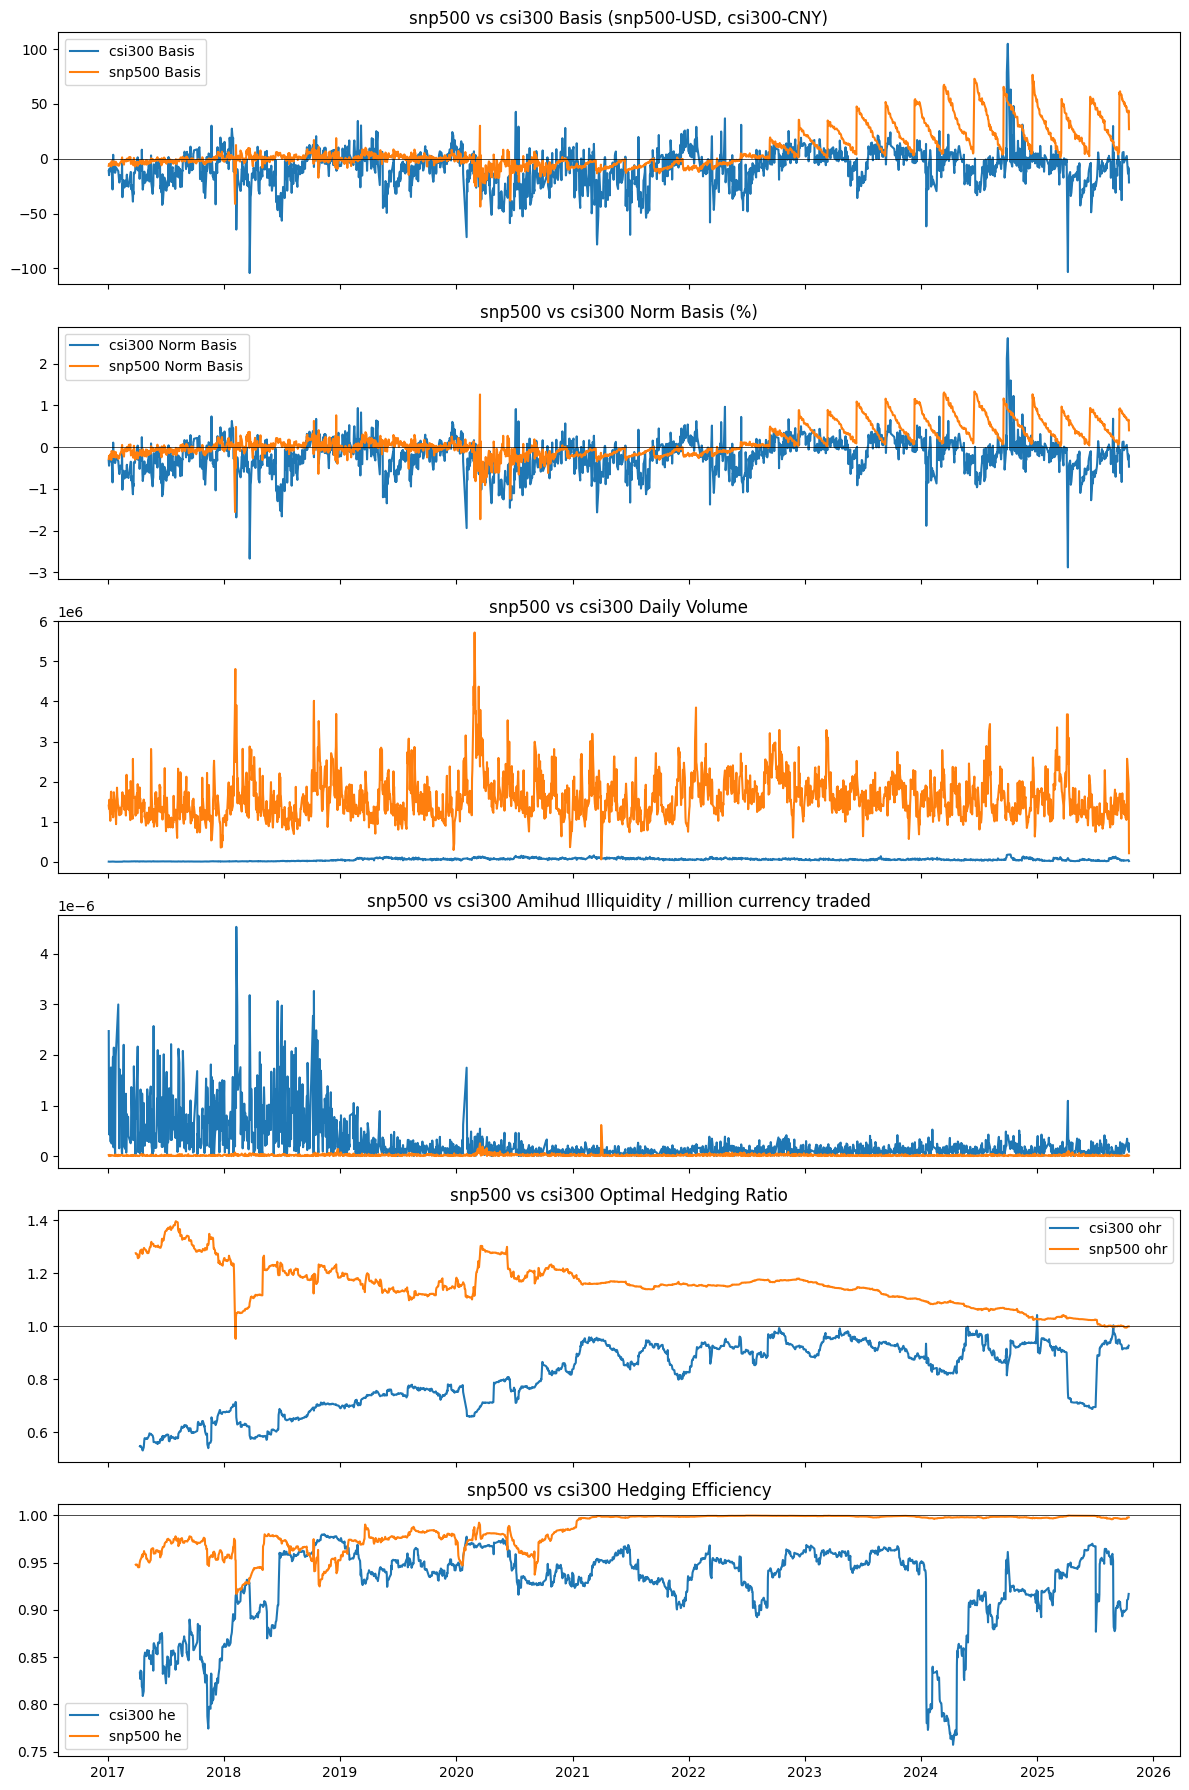

In [154]:
#funtions to plot the comparisons between the snp and csi
def plot_comparisons(cn_stats: DataFrame, us_stats: DataFrame) -> None:
    """
    Plots a series of market statistics comparisons.

    :param stats: DataFrame containing columns like 
                  'spot_close', 'fut_close', 'basis', 'norm_basis', 
                  'fut_ret', 'spot_ret', 'volume', 'open_interest', 
                  'risk_free', 'amihud_illiq', 'ohr', 'he'
    """

    plot_configs = [
        (['basis', 'basis'], ['csi300 Basis', 'snp500 Basis'], 'snp500 vs csi300 Basis (snp500-USD, csi300-CNY)', True),
        (['norm_basis', 'norm_basis'], ['csi300 Norm Basis', 'snp500 Norm Basis'], 'snp500 vs csi300 Norm Basis (%)', True),
        (['volume', 'volume'], ['csi300 Volume', 'snp500 Volume'], 'snp500 vs csi300 Daily Volume', False),
        (['amihud_illiq', 'amihud_illiq'], ['csi300 Amihud Illiq', 'snp500 Amihud Illiq'], 'snp500 vs csi300 Amihud Illiquidity / million currency traded', False),
        (['ohr', 'ohr'], ['csi300 ohr', 'snp500 ohr'], 'snp500 vs csi300 Optimal Hedging Ratio', True),
        (['he', 'he'], ['csi300 he', 'snp500 he'], 'snp500 vs csi300 Hedging Efficiency', True)
    ]

    fig, ax = plt.subplots(len(plot_configs), 1, figsize=(12, 18), sharex=True)

    for i, (cols, labels, title, add_hline) in enumerate(plot_configs):
        ax[i].plot(cn_stats.index, cn_stats[cols[0]], label=labels[0])
        ax[i].plot(us_stats.index, us_stats[cols[1]], label=labels[1])
        ax[i].set_title(title)
        if add_hline:
            if cols == ['ohr', 'ohr'] or cols == ['he', 'he']:
                ax[i].axhline(1, color='k', lw=0.5)
            else:
                ax[i].axhline(0, color='k', lw=0.5)
            ax[i].legend()

    plt.tight_layout()
    plt.show()

#plotting the comparisons
plot_comparisons(cn_stats, us_stats)

In [155]:
#funtion to plot all statistics inside our dataframe
def plot_all_stats(stats: DataFrame) -> None:
    """
    Plots a series of market statistics for a futures market.

    :param stats: DataFrame containing columns like 
                  'spot_close', 'fut_close', 'basis', 'norm_basis', 
                  'fut_ret', 'spot_ret', 'volume', 'open_interest', 
                  'risk_free', 'amihud_illiq', 'ohr', 'he'
    """
    index_name = 'Csi300' if stats is cn_stats or stats is cn_badj_stats else 'Snp500'
    risk_free_name = 'Chinese' if stats is cn_stats or stats is cn_badj_stats else 'US'

    plots = [
        (['spot_close', 'fut_close'], f'{index_name} Index Spot and Futures (Currency)', True),
        (['basis'], f'{index_name} Futures - Spot (Basis) (Currency)', True),
        (['norm_basis'], f'{index_name} Normalized Basis (%)', True),
        (['fut_ret'], f'{index_name} Change DoD in Futures Prices', False),
        (['spot_ret'], f'{index_name} Change DoD in Spot Prices', False),
        (['open_interest'], f'{index_name} Daily Open Interest on Futures', False),
        (['volume'], f'{index_name} Daily Volume on Futures', False),
        (['risk_free'], f'{risk_free_name} Risk Free Rate (%)', False),
        (['amihud_illiq'], f'{index_name} Futures Amihud Illiquidity', False),
        (['ohr'], f'{index_name} Optimal Hedge Ratio (60 day window)', False),
        (['he'], f'{index_name} Hedging Effectiveness (60 day window)', False)
    ]

    fig, ax = plt.subplots(len(plots), 1, figsize=(12, 22), sharex=True)

    for i, (cols, title, add_hline) in enumerate(plots):
        for col in cols:
            ax[i].plot(stats.index, stats[col], label=col)
        ax[i].set_title(title)
        if len(cols) > 1:
            ax[i].legend()
        if add_hline:
            ax[i].axhline(0, color='k', lw=0.5)

    plt.tight_layout()
    plt.show()


#plot_all_stats(cn_stats)
#plot_all_stats(cn_stats)

In [156]:
#function to run and ADF test on some selected data
warnings.filterwarnings("ignore")
def check_stationarity(df: pd.DataFrame, columns: list[str], name: str = None) -> pd.DataFrame:
    """
    Performs the Augmented Dickey-Fuller test for stationarity on selected columns.

    :param df: DataFrame containing time series data
    :param columns: List of column names to test
    :param name: Optional name for labeling (e.g., 'Csi300', 'Snp500')
    :return: DataFrame with ADF statistic, p-value, and stationarity conclusion
    """
    if name is None:
        name = 'Csi300' if df is cn_stats else 'Snp500'

    print(f"Running ADF test for stationarity for {columns}-{name}")

    if name is None:
        name = 'Csi300' if df is cn_stats else 'Snp500'

    results = []

    for col in columns:
        series = df[col].dropna()
        adf_result = adfuller(series)
        stat, pvalue = adf_result[0], adf_result[1]
        stationary = 'Yes' if pvalue < 0.05 else 'No'

        results.append({
            'column': f'{name} {col}',
            'adf_stat': stat,
            'p_value': pvalue,
            'stationary': stationary
        })

    return pd.DataFrame(results)

In [157]:
#function to run a Granger Causality test on some selected data
def run_granger_causality(df: pd.DataFrame, variables: list[str], max_lag: int = 5, name: str = None) -> pd.DataFrame:
    """
    Runs Granger causality tests between two variables in a DataFrame.

    :param df: DataFrame containing the time series data
    :param variables: List of two column names [predicted, used for prediction]
    :param max_lag: Maximum number of lags to test (default 5)
    :param name: Optional name for labeling (e.g., 'Csi300', 'Snp500')
    :return: DataFrame with lag and p-value of F-test
    """
    if name is None:
        name = 'Csi300' if df is cn_stats else 'Snp500'

    print(f"Testing Granger causality between {variables[1]} -> {variables[0]} ({name})")
    
    data = df[variables].dropna()
    results = grangercausalitytests(data, maxlag=max_lag, verbose=False)

    pvals = {lag: results[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)}
    summary_df = pd.DataFrame.from_dict(pvals, orient='index', columns=['p_value'])
    summary_df.index.name = 'lag'

    return summary_df

In [158]:
#running stationary tests first, then granger tests and printing the results
display(check_stationarity(cn_stats, ['abs_basis']))
display(check_stationarity(cn_stats, ['amihud_illiq']))

display(run_granger_causality(cn_stats, ['abs_basis', 'amihud_illiq']))
display(run_granger_causality(cn_stats, ['amihud_illiq', 'abs_basis'], max_lag=7)) #7 day lag to see the true relationship play out 

display(check_stationarity(us_stats, ['abs_basis']))
display(check_stationarity(us_stats, ['amihud_illiq']))

display(run_granger_causality(us_stats, ['abs_basis', 'amihud_illiq']))
display(run_granger_causality(us_stats, ['amihud_illiq', 'abs_basis']))

Running ADF test for stationarity for ['abs_basis']-Csi300


,column,adf_stat,p_value,stationary
0,Csi300 abs_basis,-5.524217,0.000002,Yes


Running ADF test for stationarity for ['amihud_illiq']-Csi300


,column,adf_stat,p_value,stationary
0,Csi300 amihud_illiq,-3.088041,0.027451,Yes


Testing Granger causality between amihud_illiq -> abs_basis (Csi300)


,p_value
lag,
1,0.350953
2,0.540441
3,0.598243
4,0.767210
5,0.479161


Testing Granger causality between abs_basis -> amihud_illiq (Csi300)


,p_value
lag,
1,0.333121
2,0.304260
3,0.304153
4,0.084004
5,0.062384
6,0.045756
7,0.047581


Running ADF test for stationarity for ['abs_basis']-Snp500


,column,adf_stat,p_value,stationary
0,Snp500 abs_basis,-6.69065,4.117874e-09,Yes


Running ADF test for stationarity for ['amihud_illiq']-Snp500


,column,adf_stat,p_value,stationary
0,Snp500 amihud_illiq,-7.13693,3.401938e-10,Yes


Testing Granger causality between amihud_illiq -> abs_basis (Snp500)


,p_value
lag,
1,0.795079
2,0.022660
3,0.056689
4,0.078446
5,0.073076


Testing Granger causality between abs_basis -> amihud_illiq (Snp500)


,p_value
lag,
1,0.006032
2,0.061883
3,0.219187
4,0.560715
5,0.738518
